# California房价预测项目

## 1. 项目大致流程

**项目目标**：利用加利福尼亚州统计局的数据，建立一个机器学习模型来预测加利福利亚州的房价。

### 1.1 建立框架

首先要了解模型的用途，这将会影响你如何对问题进行建模，选择什么样的算法和采用什么度量来衡量模型的精确性。在这个项目中，模型的输出（房价预测的结果）会和其他信号一起作为另一个机器学习系统的输入，来评估某地区的房子是否值得投资。

其次要了解该问题当前的解决方案（如果有的话）。在本案例中，当前的解决方法是靠专家手动筹集最新数据，然后根据他们设计的一些算法来计算预测房价，缺陷是耗时以及精确率不高。

最后可以开始对问题进行分析建模：
- **监督学习**：数据有标签（房价）
- **多变量回归**：房价是连续的数值，是一个回归模型。
- **批量学习**：没有连续数据流，而且数据量不是特别大，所以用批量学习。

> 当数据量特别大的时候可以用多个服务器来进行批量学习（MapReduce技术），或者采用在线学习。

## 1.2 选择度量指标（performance measure）

回归模型常用的两种：

- 均方根差（RMSE）

$$
\text{RMSE}(X, h)=\sqrt{\frac 1 m \sum_{i=1}^{m}\left( h \left( x^{(i)}\right)-y^{(i)} \right)^2}
$$

- 绝对平均误差（MAE）

$$
\text{MAE}(X, h) = \frac 1 m \sum_{i=1}^m \left| h\left(x^{(i)}\right) - y^{(i)}\right|
$$

RMSE和MAE都是衡量两个向量的距离的指标，本质上是不同的范数。RMSE对离群值（outlier）更加敏感，所以我们选择RMSE作为模型精确度的度量。

## 1.3 检验假设

这一步主要是和团队讨论交流，确保对模型做的假设没有问题。

> 比如如果模型要求输出的结果是房价的类别（“便宜”，“一般”，“昂贵”等）而不是具体的房价数值，那么这个问题就应该归为分类问题而不是回归问题。

# 2. 数据预处理

在这一步我们需要下载数据，对数据有一个基本的了解。

## 2.1 下载数据

在获得数据来源的授权之后就可以下载数据。本项目的数据存储在一个csv文件中。

由于数据可能经常发生改变，所以写一个函数来下载数据，当数据更新时就可以方便的重新获取。

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

利用Panda的`read_csv()`来加载数据。

In [4]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## 2.2 初步了解数据

利用Panda dataframe的函数可以对数据有一个初步的认识，这一步主要了解：
- 数据总量
  - 是否有丢失数据
- 变量
  - 数值or非数值
  - 对于数值变量，要了解其大致分布，中位数等等
  - 对于非数值变量，要了解其含义，计数等等
  
一些常用的函数：
- `head()`
- `info()`
- `value_count()`
- `describe()`

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


这里可以发现`total_bedroom`这个属性有缺失数据了！

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


除了以上几个panda的函数，我们还可以用画直方图的方式了解数据。

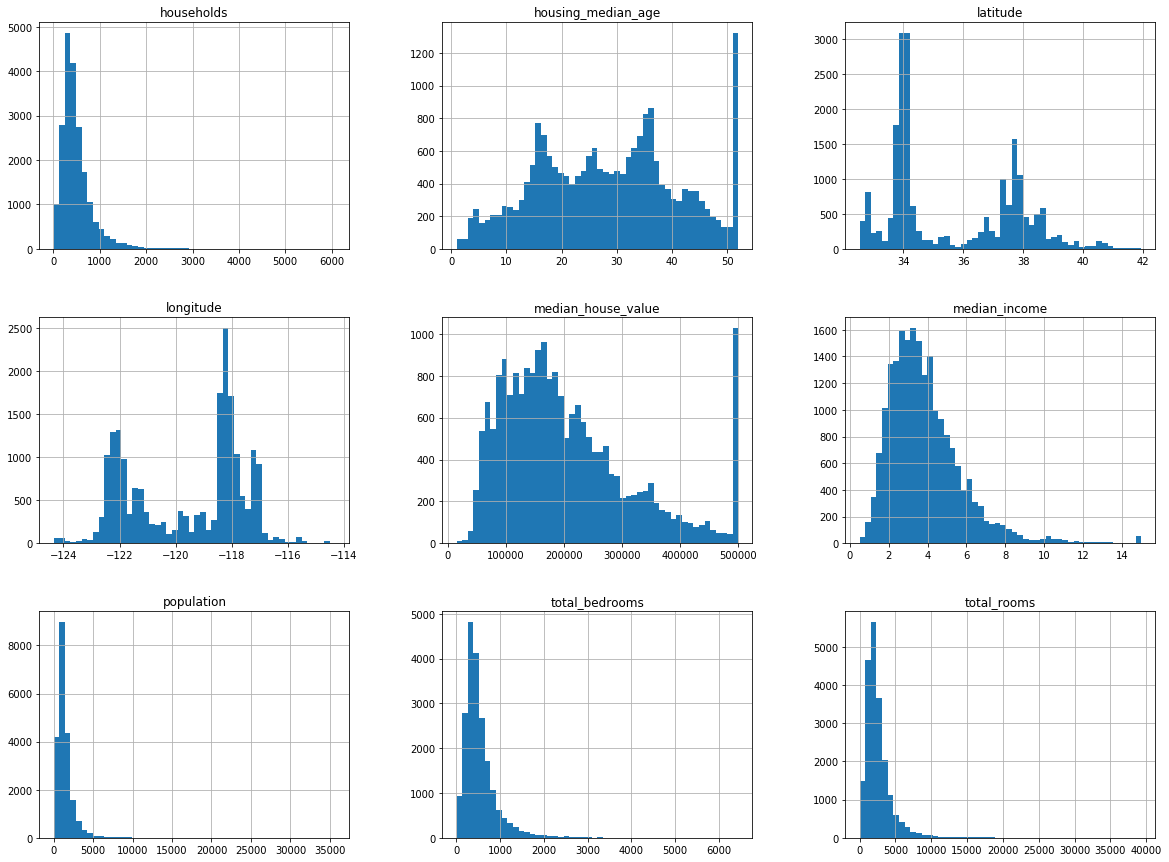

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

透过直方图我们可以发现一下几个问题：
1. `median_income`这个属性的单位显然不是美元，这个数据应该是被预处理过（可能是缩放(scale)和限制(cap)）。
2. 显然 `housing_median_age` 和 `median_house_value` 也被限制了。由于第二个元素是模型的标签值，这个限制可能导致我们模型预测的结果永远不超过500000！解决办法有两个：
  1. 重新收集被限制的数据。
  2. 将这些数据去掉。
3. 数据规模差别很大。
4. 大部分直方图都是偏的，厚尾的，这可能不利于机器学习模型去挖掘数据的模式（pattern）。

## 2.3 建立测试集

一般情况下取原数据集的20%作为测试集。

法一：利用索引的随机排列

这个方法很简便，但是当模型需要多次运行的时候，原来在测试集的数据可能跑到训练集中，这样模型就“不小心”学到了测试集数据的特性，从而降低了测试集的可靠性。

### 2.3.1 随机取样 

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


法二：如果每个数据元素有一个唯一的标识（identifier），我们就建立一个规则，当标识满足这个规则时，列入测试集。这样即使数据被增删或者程序重新运行，本属于测试集的数据都不会进入训练集。

比如我们可一个计算这个标识的散列（hash）的最后一个字节，当其值小于51（$\sim$ 20% of 256）时列入测试集。

不过在我们的数据集中并没有这样的标识符，我们可以取行号，并假设数据保存的顺序不会改变，新的数据默认加入到底部。（也可以自建一个新的标识）

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index() # add an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

法三：使用Scikit-Learn提供的函数

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 2.3.2 分层抽样（Stratified Sampling）

随机抽样在样本数据非常大的时候是可行的，但如果样本较少（尤其是相对于属性的数目），随机抽样可能会产生较大的偏差。

假设与专家交流后我们得知平均收入时预测平均房价的一个重要指标，我们应该确保测试集代表了不同等级的收入人群，所以我们应该采用分层抽样。

由于平均收入时一个连续型的属性，所以我们将收入进行分类。

In [16]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

In [17]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

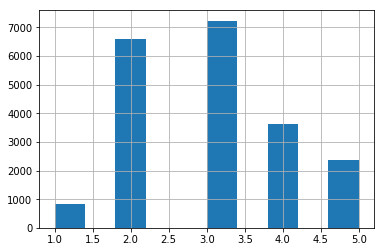

In [18]:
housing["income_cat"].hist()

然后可以利用Scikit-Learn提供的 `StratifiedShuffleSplit` 类来分层抽样选出测试集

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

由此可以大致看出，测试集的各收入人群比例和原数据集相近，下面给出分层抽样和随机抽样的各收入等级比例的比较

In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [23]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


现在我们可以把 `incom_cat` 去掉了

In [24]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# 3. 数据可视化

在进行了数据预处理和分割测试集之后，就可以开始对数据进行可视化，进行更深层次的挖掘，了解数据之间的内在联系。

注意，在这一阶段不能对测试集进行任何操作，更不能透过测试集去挖掘数据！另外，如果测试集的数据量很大，那我们就应该考虑通过分层抽样取子集来可视化，从而提高效率

In [25]:
housing = strat_train_set.copy()

## 3.1 地理数据

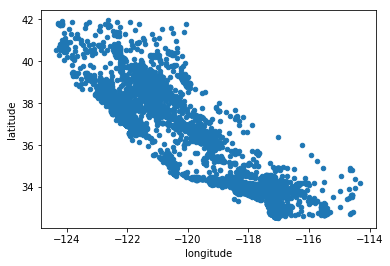

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude")

这里每个圆代表了加州的一个街区，为了区分分布密度，设置参数`alpha`为0.1

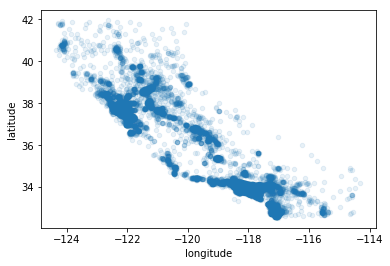

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

很显然，在海湾地区，洛杉矶，圣地亚哥，中央谷这几个地区分布比较密集。

接下来再利用圆形大小表示街区人口，颜色表示房价高低。

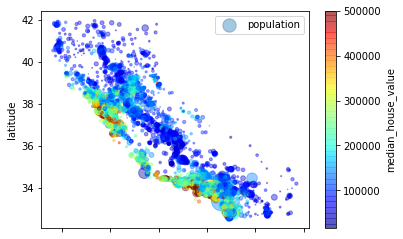

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

根据常识我们可以推断房价和地理位置以及人口密度是有关系的。这幅图正验证了这一点，沿海地区房价普遍较高，之前提到的几个地区是属于人口密集地带，房价也相对要高。这里可以考虑用聚类算法将地理位置分为几个主要类别，然后加上一个新特征度量到聚类中心的距离。

## 3.2 寻找相关性

### 3.2.1 协方差矩阵

In [29]:
corr_matrix = housing.corr()

In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

通过pandas自带的求协方差矩阵的函数，可以很直接的看到影响房价的主要线性因素：
- 平均收入
- 总房间数
- 平均房龄
- 纬度

其中有正相关也有负相关。不过要注意的是，相关系数小只代表他们的**线性关系**比较弱，不代表他们没有联系。

### 3.2.2 散点图矩阵

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253715F0A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000025372E4A390>]], dtype=object)

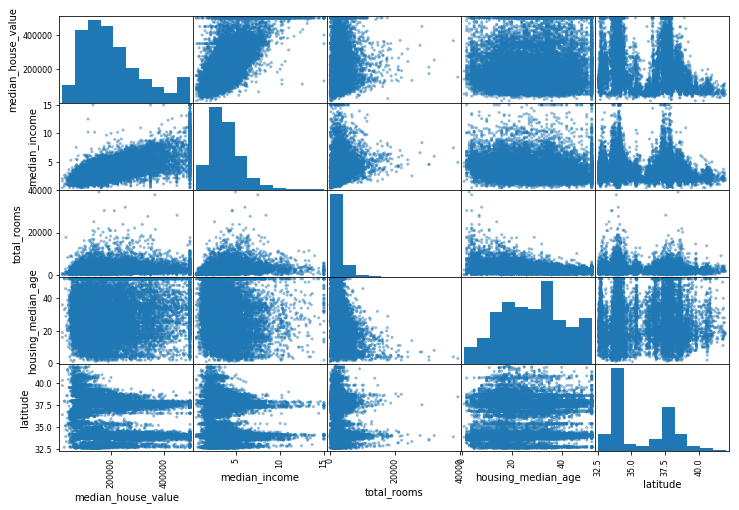

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age", "latitude"]
scatter_matrix(housing[attributes], figsize=(12, 8))

经过以上两个分析可知，平均收入是影响房价的最主要的因素，所以集中分析下两者的关系

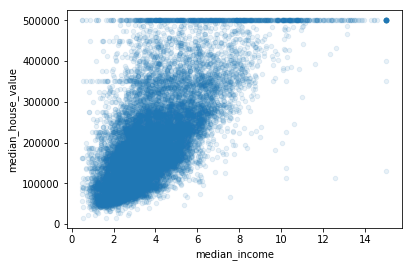

In [32]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

这个图说明了以下几点：
1. 两者的相关性确实很强，这里有一个明显的正相关性，而且点分布比较集中
2. 房价被限制（cap）在500,000是我们之前已经发现的，但在房价为约450000，350000，280000的值也有水平线。如果最后结果不理想的话可以尝试去掉这些奇怪的数据。

## 3.3 尝试属性组合

有时候，尝试一些属性的组合训练出来的模型可能会得到比原属性训练的模型效果更好。

比如这个项目中，`total_rooms` 这个属性在不知道房子总数的情况下可能并不太有用。类似的，单独从 `total_bed_rooms` 这个属性也获取不了多少信息。因此我们可以建立两个新属性：
- `rooms_per_household`
- `bedrooms_per_room`

此外，平均每个每间房子的人口数可能也有用：
- `population_per_household`


In [33]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [34]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

我们得到了一个更好的属性 `bedrooms_per_room`，相关系数达到-0.259984！`rooms_per_household` 也比原来的 `total_rooms` 提高了0.01

## 3.4 总结

这一阶段刚开始的时候可以不用做的太透彻，最重要的是先得到一个大概的了解，让模型先跑起来。然后再回过头来继续发掘数据中的信息，尝试更多的组合等等。

# 4. 数据处理

首先把训练集的属性和标签分开来

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 4.1 数据清理

根据前面的分析我们知道 `total_bedrooms` 这个数据有缺省值，机器学习算法一般不容许有缺省值，有三个解决办法：
- 去掉相应的街区数据
- 去掉整个属性
- 把缺省值设为某个值（0，均值，中位数等等）

In [36]:
#option 1
housing.dropna(subset=["total_bedrooms"])
#option 2
housing.drop("total_bedrooms", axis=1)
#option 3
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Le

Scikit-Learn提供了一个类来处理缺省值 `Imputer`，不过要注意的是 `Imputer` 只能用来处理数值类型数据，所以暂时去掉 `ocean_proximity`

- `fit()`：计算中位数并保存在 `statistics_` 中
- `trainsform()`：将缺省值替换为中位数

In [37]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median") # 表示用中位数代替缺省值

In [38]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)  
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [39]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [40]:
X = imputer.transform(housing_num)  # 计算结果储存在 Numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## 4.2 处理文本和类别属性

由于大部分机器学习算法偏向于处理数值，所以我们要把文本属性转化为数值，可利用Scikit-Learn 提供的变换器（trains former） `LabelEncoder` 来处理。

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [42]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


`LabelEncoder` 简单的把文本转换为相应的数字
- '<1H OCEAN'：0
- 'INLAND'：1
- 'ISLAND'：2
- 'NEAR BAY'：3
- 'NEAR OCEAN'：4

但这里有一个问题是，简单的对应到0-4导致这些值出现了大小关系，而机器学习算法一般认为相近的值代表着更大的相似性，即 `INLAND` 与 `ISLAND` 的相关性要大于 `INLAND` 和 `NEAR OCEAN`。这是我们不愿意看到的结果。

解决这个问题的常用方法是为每个类别建立一个二进制表征码。例如这里一共有五个类别，那么这个二进制表征码就一共有五位，当它属于类别n，那么第n为就是1，其他位置0。例：'INLAND'对应01000，'NEAR BAY'对应00010。这个编码机制叫one-hot encoding，得到的二进制表征码称为为one-hot vector。（[参考理解](https://www.jianshu.com/p/cb344e1c860a)）

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # -1 means unspecified
housing_cat_1hot  # 这里默认返回的是一个稀疏矩阵

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

Scikit-Learn提供了 `LabelBinarizer` 直接实现上述两个过程

In [45]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot  # 默认返回稠密矩阵，可设置参数 sparse_output=True

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## 4.3 自定义变换器（Transformer）

这部分属于sklearn的知识，大概就是要自己写一个类，把数据处理的操作整合到这个类里。不过这个类必须满足sklearn的一些要求，即必须有以下三个函数：
- `fit()`
- `transform()`
- `fit_transform()` （如果继承 `TransformerMixin` 则可不用写）

下面是一个将3.3中讨论的属性组合起来的transformer

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or *kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

这里将 `add_bedrooms_per_room` 作为一个超参数，这样可以方便的验证这个参数是否可以有效提高机器学习算法的预测结果。对其它不确定能否对算法产生影响的属性也可以设置为超参数。

## 4.4 特征缩放（Feature Scaling）

$$
\frac{x-\min}{\max - \min}
$$

- 最大最小值缩放（min-max scaling）
  - SkLearn提供 `MinMaxScaler` 变换器。其中超参数 `feature_range` 用来改变缩放之后值的范围。
  
$$
\frac{x - \mu}{\sigma}
$$

- 标准化（standardization）
  - 受离群值（outlier）影响较小。
  - 期望为0， 方差为1，但数据不限制在某个范围
  - SkLearn提供 `StandardScaler` 变换器。

## 4.5 数据变换流（Transformation Pipelines）

以上我们看到，将数据用于训练机器学习模型之前通常要进行一系列的数据变换。SkLearn提供了 `Pipeline` 类来整合这些数据变换。

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

`Pipeline` 的构造函数接受一系列（名字，估计器）的二元组作为参数。这些二元组决定了数据处理的顺序。除了最后一个之外都必须是 Transformer。

当调用 `Pipeline` 的 `fit()` 函数时，它会依次调用所有 `Transformer` 的 `fit_transform()` 函数，每次调用的输出作为下一个调用的输入，直到最后一个estimator，调用它的 `fit()` 函数。

上面这个 pipeline 实现了数值数据的变换，我们还需要对分类变量调用 `LabelBinarizer`。

SkLearn提供了 `FeatureUnion` 类可以整合多个 `pipeline`，并行的调用他们。每个子 `pipeline` 的第一个 `transformer` 是 `selector`，它的作用是
- 选择需要的属性（数值变量或分类变量）
- 去掉其余的属性
- 把 Pandas DataFrame 转换成 NumPy array

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values # 转换为 np array

In [49]:
# 这个类主要是解决 LabelBinarizer() 在 pipeline 运行出错的问题
# cr：https://stackoverflow.com/questions/46162855/fit-transform-takes-2-positional-arguments-but-3-were-given-with-labelbinarize
from sklearn.base import TransformerMixin # give fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=None):
        return self.encoder.transform(X)

In [50]:
# alternative solution
# cr.https://github.com/scikit-learn/scikit-learn/pull/7375/files#diff-1e175ddb0d84aad0a578d34553f6f9c6
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [51]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizerPipelineFriendly()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [52]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# 5. 训练模型

## 5.1 用训练集进行训练和测试

### 5.1.1 线性回归

In [53]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
# incences from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Prediction:\t", lin_reg.predict(some_data_prepared))

Prediction:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


In [55]:
print("Labels:\t\t", list(some_labels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [56]:
# 测量RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [57]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

房价的范围是[14999, 500001]，误差为68628显然太大了，这是典型的欠拟合。

### 5.1.2 决策树

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse

0.0

误差为0，极有可能是过拟合，这样的模型泛化能力很差

## 5.2 交叉验证

**在选择模型的过程中**，应当把训练集再分出一个验证集，用来评估模型的选择。可以利用SkLearn提供的交叉验证功能。

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([ 68258.89988652,  67698.69687999,  70631.25964846,  70280.44554988,
        70864.72281208,  75426.9548016 ,  71834.78502167,  70324.61320687,
        76175.23713646,  70401.52043207])

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(rmse_scores)

Scores: [ 68258.89988652  67698.69687999  70631.25964846  70280.44554988
  70864.72281208  75426.9548016   71834.78502167  70324.61320687
  76175.23713646  70401.52043207]
Mean: 71189.7135376
Standard deviation: 2581.01815589


决策树模型的误差大约为 $[70761.7-2788.8, 70761.7+2788.8]$，比线性回归模型还差。交叉验证可以很好的评估模型，但交叉验证需要多次训练模型，所以并不总是适用。

## 5.3 集成学习

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22199.35708627609

In [63]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52616.55375647  50159.11100451  51684.71819077  54356.44552263
  52317.73994786  56008.50882466  51411.53801037  50857.31908105
  55548.43949331  52462.41344252]
Mean: 52742.2787274
Standard deviation: 1858.43562584


## 5.4 保存模型

In [64]:
from sklearn.externals import joblib

joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(tree_reg, "tree_reg")
joblib.dump(forest_reg, "forest_reg")

# 导入模型
# lin_reg_loaded = joblib.load("lin_reg.pkl")

['forest_reg']

# 6. 模型调参

选择好模型之后，需要对模型进行调参。即尝试不同的超参数组合，使模型获得更好的效果。

## 6.1 Grid Search

SkLearn提供了 `GridSearchCV` 来搜索参数，不过需要手动提供可选的参数值。如果不知道参数应该选什么好，可以尝试10的不同次幂。（0.1， 1， 10， 100 ...)

### 6.1.1 随机森林

In [71]:
from sklearn.model_selection import GridSearchCV

# 暂时不需要直到这些参数的含义，后面会讲
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [72]:
# 查看最佳参数组合
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

`n_estimators` 的值选了最大的30，无法确定是不是最优，所以需要尝试更大的值。

In [73]:
param_grid = [
    {'n_estimators': [100, 500, 1000], 'max_features': [4, 6, 8]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 500, 1000], 'max_features': [4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 500}

In [75]:
# 查看最优模型
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [76]:
# 查看所有参数的RMSE
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49668.494439 {'max_features': 4, 'n_estimators': 100}
49429.1244328 {'max_features': 4, 'n_estimators': 500}
49355.368438 {'max_features': 4, 'n_estimators': 1000}
49331.6746259 {'max_features': 6, 'n_estimators': 100}
48925.0349966 {'max_features': 6, 'n_estimators': 500}
48965.4071208 {'max_features': 6, 'n_estimators': 1000}
49337.3726835 {'max_features': 8, 'n_estimators': 100}
48987.9137627 {'max_features': 8, 'n_estimators': 500}
48999.2133228 {'max_features': 8, 'n_estimators': 1000}


## 6.2 Randomized Search

Grid Search的一个缺点是，需要手动提供超参数的可选值，比较适合参数组合少的情况。当超参数的搜索空间特别大时，通常我们选择使用Randomized Search，由SkLearn的 `RandomizedSearchCV` 提供支持。

## 6.3 集成方法（Ensemble Methods）

另外一种调参的方法是，将多个效果比较好的模型集成为一个模型，继承模型的效果一般比单个子模型要好。

# 7. 最优模型和误差分析

## 7.1 最优模型分析

得到最优模型后，可以对模型进行分析从而对数据由更深刻的认识。`RandomForestRegressor` 提供了 `feature_importances_` 变量，显示了不同特征的相对重要性。

In [77]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_household", "populations_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33044175462264569, 'median_income'),
 (0.15151101687721918, 'INLAND'),
 (0.10813126584883065, 'populations_per_household'),
 (0.075811030202721258, 'longitude'),
 (0.072981187360396202, 'bedrooms_per_room'),
 (0.068716599180757329, 'latitude'),
 (0.060911503272013348, 'rooms_per_household'),
 (0.042743765161472984, 'housing_median_age'),
 (0.017737079086966298, 'population'),
 (0.017462911364067409, 'total_rooms'),
 (0.016791717404750026, 'total_bedrooms'),
 (0.016227027389417822, 'households'),
 (0.011425353939307957, '<1H OCEAN'),
 (0.0049735433917766107, 'NEAR OCEAN'),
 (0.0040625577181094058, 'NEAR BAY'),
 (7.168717954728342e-05, 'ISLAND')]

由此我们可以看到之前没发现的一个特性：是否属于 `INLAND` 对房价的预测影响很大！

## 7.2 利用测试集进行误差分析

In [78]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46766.088123163514

`final_rmse` 就是最后对该模型的误差分析。一般来说，模型在测试集的RMSE会比在验证集上的大，因为在调参的过程中实际上会学到验证集的一些特性。

# END

-----

# 补充内容

# 支持向量机（SVM）

In [120]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="rbf")
svm_reg.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)

In [121]:
svm_rmse

118577.43356412371

### 6.1.2 SVM

In [127]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [0.1, 0.5, 1, 10]}, {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.1, 0.5, 1, 10], 'gamma': ['auto', 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [128]:
grid_search.best_params_

{'C': 10, 'kernel': 'linear'}

In [131]:
best_svm_rmse = np.sqrt(-grid_search.best_score_)
best_svm_rmse

84654.089300213804